# Cahn-Hilliard Example

This example demonstrates how to use PyMKS to solve the Cahn-Hilliard equation. The first section provides some background information about the Cahn-Hilliard equation as well as details about calibrating and validating the MKS model. The example demonstrates how to generate sample data, calibrate the influence coefficients and then pick an appropriate number of local states when state space is continuous. The MKS model and a spectral solution of the Cahn-Hilliard equation are compared on a larger test microstructure over multiple time steps.

### Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy
import dask.array as da
import matplotlib.pyplot as plt
from dask_ml.model_selection import train_test_split, GridSearchCV
from distributed import Client
from sklearn.pipeline import Pipeline

from pymks import (
    solve_cahn_hilliard,
    plot_microstructures,
    PrimitiveTransformer,
    LocalizationRegressor,
    ReshapeTransformer,
    coeff_to_real
)

In [3]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://127.0.0.1:35835 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 67.15 GB


## Modeling with MKS

In this example the MKS equation will be used to predict microstructure at the next time step using 

$$p[s, 1] = \sum_{r=0}^{S-1} \alpha[l, r, 1] \sum_{l=0}^{L-1} m[l, s - r, 0] + ...$$

where $p[s, n + 1]$ is the concentration field at location $s$ and at time $n + 1$, $r$ is the convolution dummy variable and $l$ indicates the local states varable. $\alpha[l, r, n]$ are the influence coefficients and $m[l, r, 0]$ the microstructure function given to the model. $S$ is the total discretized volume and $L$ is the total number of local states `n_states` choosen to use.

The model will march forward in time by recursively replacing discretizing $p[s, n]$ and substituing it back for $m[l, s - r, n]$.

### Calibration Datasets

Unlike the elastostatic examples, the microstructure (concentration field) for this simulation doesn't have discrete phases. The microstructure is a continuous field that can have a range of values which can change over time, therefore the first order influence coefficients cannot be calibrated with delta microstructures. Instead, a large number of simulations with random initial conditions are used to calibrate the first order influence coefficients using linear regression.

The function `solve_cahn_hilliard` provides an interface to generate calibration datasets for the influence coefficients.

In [2]:
da.random.seed(99)

x_data = (2 * da.random.random((100, 41, 41), chunks=(20, 41, 41)) - 1).persist()

y_data = solve_cahn_hilliard(x_data, delta_t=1e-2).persist()

In [3]:
x_data

dask.array<sub, shape=(100, 41, 41), dtype=float64, chunksize=(20, 41, 41), chunktype=numpy.ndarray>

In [4]:
y_data

dask.array<iterate_times, shape=(100, 41, 41), dtype=float64, chunksize=(20, 41, 41), chunktype=numpy.ndarray>

Plot the first microstructure and its response.

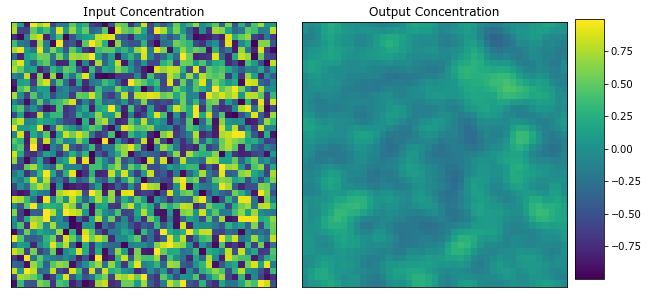

In [5]:
plot_microstructures(x_data[0], y_data[0], titles=("Input Concentration", "Output Concentration"))

## The Model

Construct the modeling pipeline and visualizet the task graph. Here a pipeline is used which includes a ReshapeTransformer. This reshapes the data as both the PrimitiveTransformer and the LocalizationRegressor assume that the data is an image while Sklearn uses flat (n_sample, n_feature) data.

In [6]:
model = Pipeline(steps=[
    ('reshape', ReshapeTransformer(shape=x_data.shape)),
    ('discretize', PrimitiveTransformer(n_state=5, min_=-1.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])    

Fontconfig warning: "/etc/fonts/fonts.conf", line 5: unknown element "its:rules"
Fontconfig warning: "/etc/fonts/fonts.conf", line 6: unknown element "its:translateRule"
Fontconfig error: "/etc/fonts/fonts.conf", line 6: invalid attribute 'translate'
Fontconfig error: "/etc/fonts/fonts.conf", line 6: invalid attribute 'selector'
Fontconfig error: "/etc/fonts/fonts.conf", line 7: invalid attribute 'xmlns:its'
Fontconfig error: "/etc/fonts/fonts.conf", line 7: invalid attribute 'version'
Fontconfig warning: "/etc/fonts/fonts.conf", line 9: unknown element "description"
Fontconfig error: Cannot load config file from /etc/fonts/fonts.conf


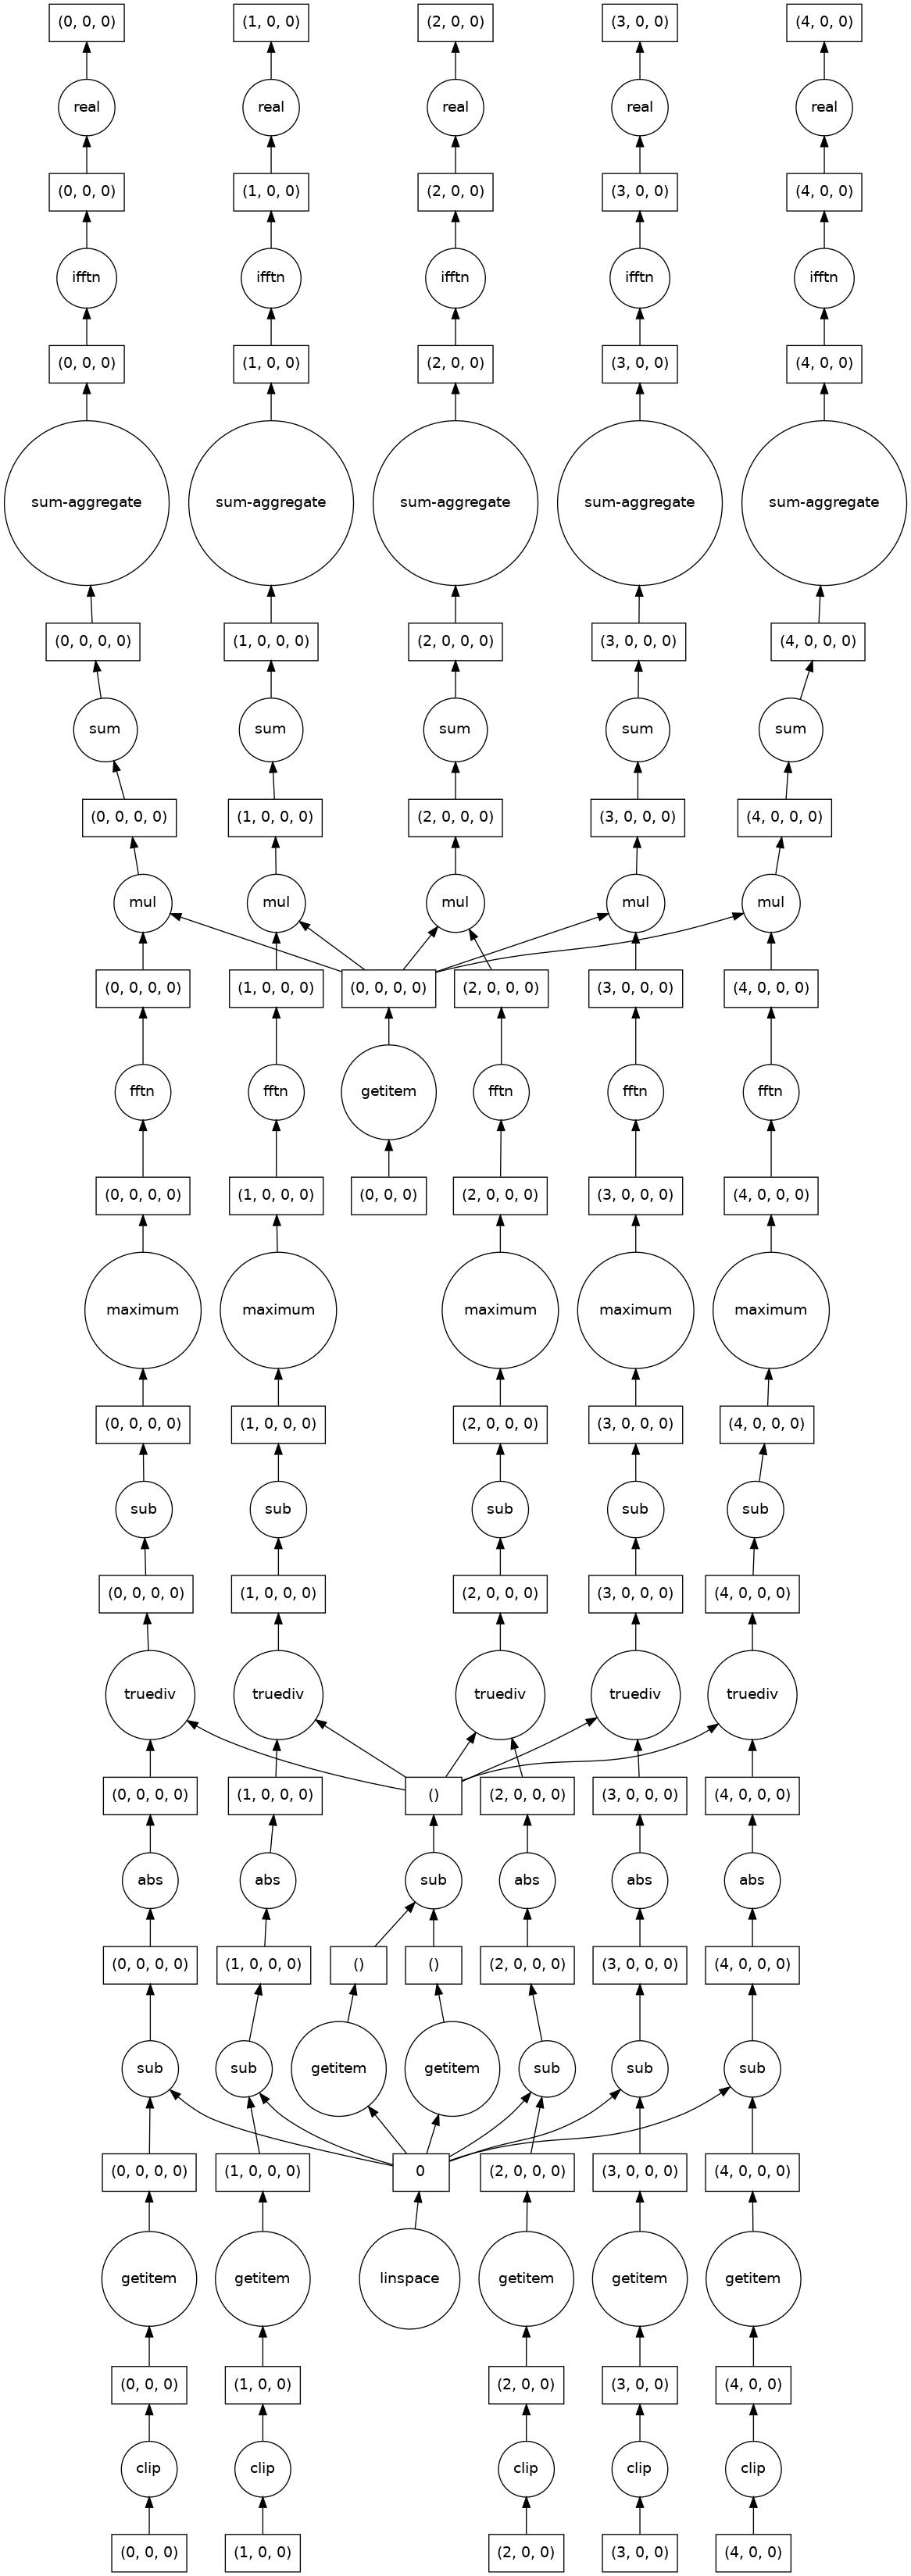

In [7]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

model.fit(x_data, y_data).predict(x_data).visualize()

## Optimizing the Number of Local States

As mentioned above, the microstructures (concentration fields) does not have discrete phases. This leaves the number of local states in local state space as a free hyperparameter. In previous work it has been shown that, as you increase the number of local states, the accuracy of MKS model increases (see [Fast et al.](http://dx.doi.org/10.1016/j.actamat.2010.10.008)), but, as the number of local states increases, the difference in accuracy decreases. Some work needs to be done in order to find the practical number of local states that we will use. 

Split the calibrate dataset into test and training datasets. The function `train_test_split` for the machine learning Python module [dask_ml](http://dask-ml.readthedocs.io/en/latest/index.html) provides a convenient interface to do this. 80% of the dataset will be used for training and the remaining 20% will be used for testing by setting `test_size` equal to 0.2.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data.reshape(x_data.shape[0], -1),
    y_data.reshape(y_data.shape[0], -1),
    test_size=0.2
)

Calibrate the influence coefficients while varying the number of local states from 2 up to 11. Each of these models will then predict the evolution of the concentration fields. Mean square error will be used to compare the results with the testing dataset to evaluate how the MKS model's performance changes as we change the number of local states.

In [9]:
params = dict(discretize__n_state=range(2, 11))
grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train);

In [10]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print(grid_search.best_estimator_)
print(grid_search.score(x_test, y_test))

Pipeline(memory=None,
         steps=[('reshape', ReshapeTransformer(shape=(100, 41, 41))),
                ('discretize',
                 PrimitiveTransformer(chunks=None, max_=1.0, min_=-1.0,
                                      n_state=10)),
                ('regressor',
                 LocalizationRegressor(redundancy_func=<function LocalizationRegressor.<lambda> at 0x7f1dbc502320>))],
         verbose=False)
0.9999989641250209


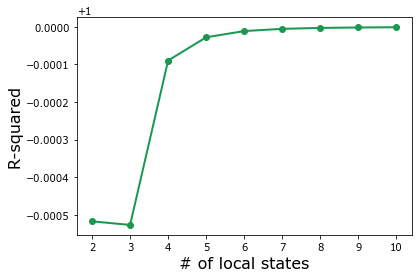

In [11]:
plt.plot(params['discretize__n_state'],
         grid_search.cv_results_['mean_test_score'],
         'o-',
         color='#1a9850',
         linewidth=2)
plt.xlabel('# of local states', fontsize=16)
plt.ylabel('R-squared', fontsize=16);

As expected, the accuracy of the MKS model monotonically increases with `n_state`, but accuracy doesn't improve significantly as `n_state` gets larger than single digits. 

To save on computation costs, set (calibrate) the influence coefficients with `n_state` equal to 6, but realize that `n_state` can be increased for more accuracy

In [13]:
model.set_params(discretize__n_state=6)

model.fit(x_train, y_train);

Here are the first 4 influence coefficients. 

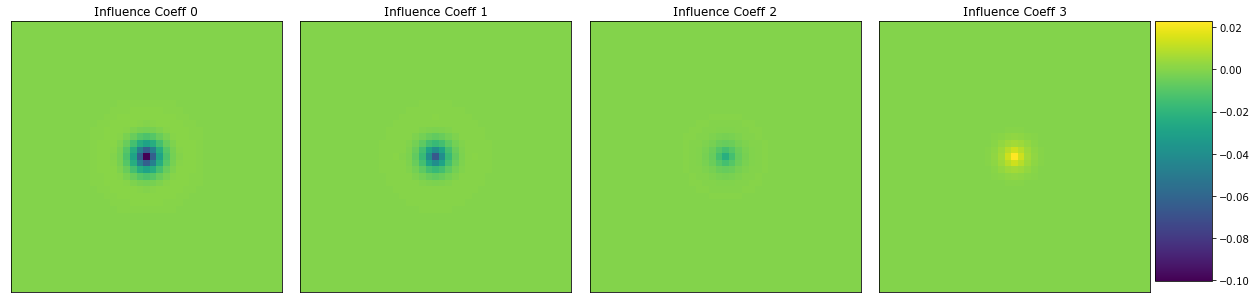

In [14]:
fcoeff = model.steps[2][1].coeff
coeff = coeff_to_real(fcoeff)

plot_microstructures(
    coeff.real[..., 0],
    coeff.real[..., 1],
    coeff.real[..., 2],
    coeff.real[..., 3],
    titles=['Influence Coeff {0}'.format(i) for i in range(4)]
)

### Predict Microstructure Evolution

After calibration, the evolution of the concentration field can be predicted. First generate a test sample.

In [15]:
da.random.seed(99)

x_test = (2 * da.random.random((1, 41, 41), chunks=(1, 41, 41)) - 1).persist()
y_test = solve_cahn_hilliard(x_test, n_steps=10, delta_t=1e-2).persist()

Iterate the model forward 10 times to match the parameter `n_steps`.

In [16]:
y_predict = x_test

for _ in range(10):
    y_predict = model.predict(y_predict).persist()

View the concentration fields.

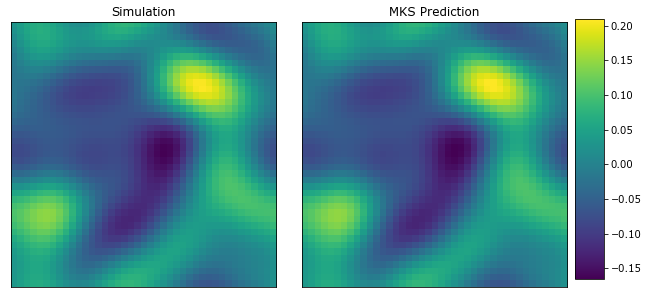

In [17]:
plot_microstructures(y_test[0], y_predict.reshape((1, 41, 41))[0], titles=('Simulation', 'MKS Prediction'))

The MKS model was able to capture the microstructure evolution with 6 local states. 

## Resizing the Coefficients to use on Larger Systems 

Predict a larger simulation by resizing the coefficients and provide a larger initial concentration field. First generate a test sample for a system 3x as large.

In [18]:
da.random.seed(99)

shape = (1, x_data.shape[1] * 3, x_data.shape[1] * 3)

x_large = (2 * da.random.random(shape, chunks=shape) - 1).persist()
y_large = solve_cahn_hilliard(x_large, n_steps=10, delta_t=1e-2).persist()

Resize the coefficients and the reshape transformer.

In [19]:
model.steps[0][1].shape = shape
model.steps[2][1].coeff_resize(shape[1:]);

Use the model to predict the data by iterating `n_steps` forward.

In [20]:
y_large_predict = x_large

for _ in range(10):
    y_large_predict = model.predict(y_large_predict).persist()

View the final structure.

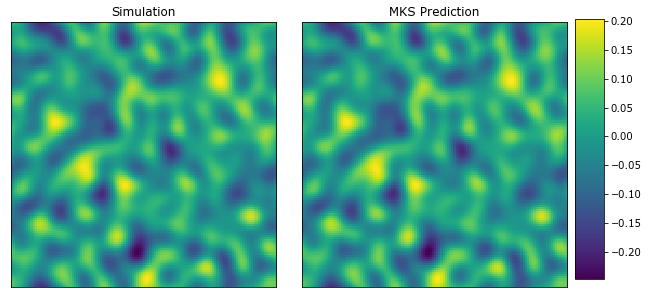

In [21]:
plot_microstructures(y_large[0], y_large_predict.reshape(shape)[0], titles=('Simulation', 'MKS Prediction'))

The MKS model with resized influence coefficients was able to reasonably predict the structure evolution for a larger concentration field. 